In [12]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
json_list = json.load((open('ultimate_data_challenge.json')))
#json_df = pd.read_json('ultimate_data_challenge.json', orient = 'table')
json_df = pd.DataFrame(json_list)

## Exploratory Analysis - Visualization

Since we're looking to see if the user was still active more than 5 months after their signup date, we:
- first, compute a column indicating the number of months between sign up and last trip
- second, classify if the time period is greater than 5 months

In [14]:
json_df['user_age_months'] = (pd.to_datetime(json_df['last_trip_date'])-pd.to_datetime(json_df['signup_date']))/np.timedelta64(1, 'M')
json_df['active_user_6months'] = np.where(json_df['user_age_months']>5,1,0)
json_df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,user_age_months,active_user_6months
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,4.698248,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,3.154069,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0.032855,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,5.585330,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,1.544180,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,4.303990,0
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0,0.032855,0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0,3.646892,0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5,0.032855,0


We run some basic analysis on our new data, and search for correlation between some of the features variables

In [44]:
json_df.active_user_6months.value_counts(normalize=True)

0    0.77612
1    0.22388
Name: active_user_6months, dtype: float64

We first notice that only 22% of users remained active 5 months after signing up

### Non numerical data

Before we start, let's make sure that we have no missing data

In [15]:
json_df.phone.fillna('Other_Phone', inplace=True)
pd.crosstab(json_df['phone'], json_df['active_user_6months'], dropna = False)

active_user_6months,0,1
phone,,
Android,13273,1749
Other_Phone,319,77
iPhone,25214,9368


As we can see, 27% of iPhone users are retained, compared to 13% for Androids. This is a substantial improvement that we should account in our model

In [46]:
json_df.ultimate_black_user.fillna('Other', inplace=True)
pd.crosstab(json_df['ultimate_black_user'], json_df['active_user_6months'])

active_user_6months,0,1
ultimate_black_user,,
False,25732,5414
True,13074,5780


Meanwhile, 44% of those who rode Ultimate Black at least once ended up being active after 5 months, against 21% for those who didn't. Again, we should account that in our model.

In [47]:
json_df.city.fillna('Other', inplace=True)
pd.crosstab(json_df['city'], json_df['active_user_6months'])

active_user_6months,0,1
city,,
Astapor,14065,2469
King's Landing,6471,3659
Winterfell,18270,5066


It seems like King's Landing is the city with the most retainers.

### Numerical Data

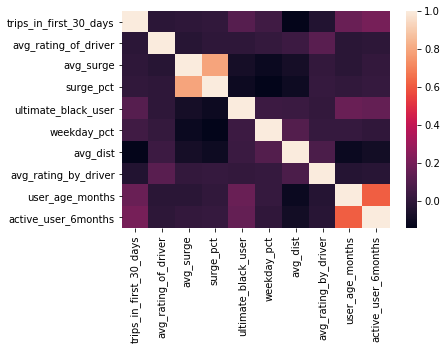

In [48]:
corr1 = json_df.corr(method='pearson')
sns.heatmap(corr1, annot=False)

Let's see the numerical features that correlate the most with our data

In [49]:
corr1['active_user_6months'].sort_values(ascending=False)

active_user_6months       1.000000
user_age_months           0.610992
trips_in_first_30_days    0.200563
ultimate_black_user       0.154334
surge_pct                 0.018170
avg_surge                 0.007247
weekday_pct               0.001407
avg_rating_of_driver     -0.007815
avg_rating_by_driver     -0.021244
avg_dist                 -0.089616
Name: active_user_6months, dtype: float64

We will toss out all those with less than .03 correlation in absolute value. For now, let's add the dummies variables

In [61]:
city_dummies = pd.get_dummies(json_df['city'])
phone_dummies = pd.get_dummies(json_df['phone'])
df = json_df[['active_user_6months','trips_in_first_30_days','ultimate_black_user','avg_dist']].join(city_dummies).join(phone_dummies)

df

,active_user_6months,trips_in_first_30_days,ultimate_black_user,avg_dist,Astapor,King's Landing,Winterfell,Android,Other_Phone,iPhone
0,0,4,True,3.67,0,1,0,0,0,1
1,0,0,False,8.26,1,0,0,1,0,0
2,0,3,False,0.77,1,0,0,0,0,1
3,1,9,True,2.36,0,1,0,0,0,1
4,0,14,False,3.13,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...
49995,0,0,False,5.63,0,1,0,0,0,1
49996,0,1,False,0.00,1,0,0,0,0,1
49997,0,0,True,3.86,0,0,1,1,0,0
49998,0,2,False,4.58,1,0,0,0,0,1


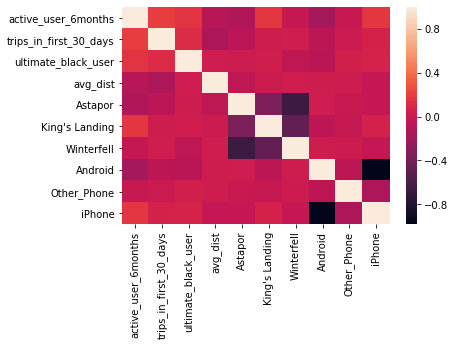

In [18]:
corr2 = df.corr(method='pearson')
sns.heatmap(corr2, annot=False)

In [19]:
corr2['active_user_6months'].sort_values(ascending=False)

active_user_6months       1.000000
trips_in_first_30_days    0.200563
iPhone                    0.168908
King's Landing            0.166057
ultimate_black_user       0.154334
Other_Phone              -0.006309
Winterfell               -0.015240
avg_dist                 -0.089616
Astapor                  -0.125710
Android                  -0.168929
Name: active_user_6months, dtype: float64

In [63]:
df.describe()

,active_user_6months,trips_in_first_30_days,avg_dist,Astapor,King's Landing,Winterfell,Android,Other_Phone,iPhone
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.223880,2.278200,5.796827,0.330680,0.202600,0.466720,0.300440,0.007920,0.691640
std,0.416847,3.792684,5.707357,0.470463,0.401941,0.498896,0.458454,0.088642,0.461821
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,3.880000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,3.000000,6.940000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,125.000000,160.960000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Machine Learning - Classifier Model

We first build a predictive model based on those left over features. We'll first transform the data to take care of missing values then use the Logistic Regressor of Scikit Learn to classify the target value

In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer as Imputer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV,  cross_val_score

### With most important features

In [65]:
numeric_features = ['trips_in_first_30_days','avg_dist']
transformer = Pipeline(steps = [('imputer', Imputer(strategy='mean')),('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', transformer, numeric_features)])

classifier = LogisticRegression()
pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', classifier)])

param_grid = {
    'classifier__C': np.logspace(-5, 8, 15),
    'classifier__penalty': ['l2']}

In [87]:
Xp = df.drop(['active_user_6months'], axis=1)
yp = df['active_user_6months']

X, X_val, y, y_val = train_test_split(Xp, yp, test_size=0.02)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


gm_cv = GridSearchCV(pipeline, param_grid, cv = 5)
gm_cv.fit(X_train, y_train)
print("Tuned Metric:", gm_cv.score(X_test, y_test))
print("Tuned C value: {}".format(gm_cv.best_params_))

Tuned Metric: 0.7790476190476191
Tuned C value: {'classifier__C': 0.006105402296585327, 'classifier__penalty': 'l2'}


Let's pick a random user from the validation set and compute the probability it be active in 6 months.

In [101]:
print("The probability the user will be active is" ,gm_cv.predict_proba(X_val)[2,0])
print("while in fact that user being active was ", y_val.iloc[2]==1)

The probability the user will be active is 0.814217005377424
while in fact that user being active was  True


### With all features

In [57]:
cols2 =['active_user_6months', 'trips_in_first_30_days','ultimate_black_user','avg_dist',
        'avg_rating_of_driver','avg_surge', 'surge_pct', 'weekday_pct', 'avg_rating_by_driver']
df2 = json_df[cols2].join(city_dummies).join(phone_dummies)

df2

,active_user_6months,trips_in_first_30_days,ultimate_black_user,avg_dist,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_rating_by_driver,Astapor,King's Landing,Winterfell,Android,Other_Phone,iPhone
0,0,4,True,3.67,4.7,1.10,15.4,46.2,5.0,0,1,0,0,0,1
1,0,0,False,8.26,5.0,1.00,0.0,50.0,5.0,1,0,0,1,0,0
2,0,3,False,0.77,4.3,1.00,0.0,100.0,5.0,1,0,0,0,0,1
3,1,9,True,2.36,4.6,1.14,20.0,80.0,4.9,0,1,0,0,0,1
4,0,14,False,3.13,4.4,1.19,11.8,82.4,4.9,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,False,5.63,5.0,1.00,0.0,100.0,4.2,0,1,0,0,0,1
49996,0,1,False,0.00,NaN,1.00,0.0,0.0,4.0,1,0,0,0,0,1
49997,0,0,True,3.86,5.0,1.00,0.0,100.0,5.0,0,0,1,1,0,0
49998,0,2,False,4.58,3.0,1.00,0.0,100.0,3.5,1,0,0,0,0,1


In [59]:
numeric_features = ['trips_in_first_30_days','ultimate_black_user','avg_dist',
        'avg_rating_of_driver','avg_surge', 'surge_pct', 'weekday_pct', 'avg_rating_by_driver']
transformer = Pipeline(steps = [('imputer', Imputer(strategy='mean')),('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', transformer, numeric_features)])

classifier = LogisticRegression()
pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', classifier)])

param_grid = {
    'classifier__C': np.logspace(-5, 8, 15),
    'classifier__penalty': ['l2']}

In [60]:
X = df2.drop(['active_user_6months'], axis=1)
y = df2['active_user_6months']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


gm_cv = GridSearchCV(pipeline, param_grid, cv = 5)
gm_cv.fit(X_train, y_train)
print("Tuned Metric:", gm_cv.score(X_test, y_test))
print("Tuned C value: {}".format(gm_cv.best_params_))

Tuned Metric: 0.7816666666666666
Tuned C value: {'classifier__C': 0.05179474679231213, 'classifier__penalty': 'l2'}


## The predictive model and Discussions
<div class="alert alert-success">
    Comments:
    
- We decided to use the Logistic Regressor of Scikit Learn to determine if a user will be active in their 6 month. We could have used KNeighborsClassifier, RandomForestClassifier, SVC instead to say the least.
    
- Using a random train-split method, we found that the model was 77% accurate (the default metric). We chose accuracy since we're not explicitely told which category of users we want the model to run best on. However, I believe the model should be based on its ability to predict the number of active users, hence precision or recall could have been used as metric.

- We also only build two models: one that accounts only for the most important features (those that correlated the most with the target) and one that includes all features. Including all features barely improve the model's performance (by less than 1%). Therefore, it is of importance that Ultimate rely on those important features, which are: the number of trips in first 30 days, the usage of Ultimate_Black, the avg distance of each trip, the city and the phone type.

- We also saved a hold out set on which we can use the predict_proba function. If the company is willing, it can then determine the likeliness of a user to remain active after 6 months using the important features listed above.

- The only downside of all this is that 77% accuracy isn't terribly great: the model can make prediction errors.

    </div>